# "SageMaker Regression on Abalone Data"

> Estimation of the age of an abalone using readily available measurements
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/Abalone_Regression_SageMaker.jpg
- categories: [Fishing-Industry,  Regression,  AWS-Sagemaker,Linear-Learner]
- show_tags: true

## 1. Introduction
What is Abalone? It is a large marine gastropod mollusk that lives in coastal saltwater and is a member of the Haliotidae family. Abalone is often found around the waters of South Africa, Australia, New Zealand, Japan, and the west coast of North America. The abalone shell is flat and spiral-shaped with several small holes around the edges. It has a single shell on top with a large foot to cling to rocks and lives on algae. Sizes range from 4 to 10 inches. The interior of the shell has an iridescent mother of pearl appearance (Figure 1).

![Figure 1  Abalone shell](../images/Abalone_Regression_SageMaker_fig1.jpg "Figure 1  Abalone shell")

As a highly prized culinary delicacy (Figure 2), it has a rich, flavorful taste that is sweet buttery, and salty. Abalone is often sold live in the shell, but also frozen, or canned. It is among the world's most expensive seafood. For preparation it is often cut into thick steaks and pan-fried. It can also be eaten raw.

![Figure 2  Abalone ready for the eating](../images/Abalone_Regression_SageMaker_fig2.jpg "Figure 2  Abalone ready for the eating")


## 2. Data Understanding
There is more information on the Abalone Dataset available at 
[UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). 

The dataset has 9 features:

* Rings (number of)
* sex (M, F, Infant)
* Length (Longest shell measurement in mm)
* Diameter (in mm)
* Height (with meat in shell, in mm)
* Whole Weight (whole abalone, in grams)
* Shucked Weight (weight of meat, in grams)
* Viscera Weight (gut weight after bleeding, in grams)
* Shell Weight (after being dried, in grams)

The number of rings indicates the age of the abalone. The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope. Not only is this a boring and time-consuming task but it is also relatively expensive in terms of waste. The remaining measurements, on the other hand, are readily achievable with the correct tools, and with much less effort. The purpose of this model is to estimate the abalone age, specifically the number of rings, based on the other features.

### 2.0 Setup

In [1]:
import urllib.request
import pandas as pd
import seaborn as sns
import random
# from IPython.core.debugger import set_trace
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from time import gmtime, strftime
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
# import json
# from itertools import islice
# import math
# import struct
!pip install smdebug
from smdebug.trials import create_trial
import matplotlib.pyplot as plt
import re

[2021-05-24 13:28:27.782 ip-172-16-88-149:11789 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [2]:
# hide
region = boto3.Session().region_name; print('region:', region)
role = sagemaker.get_execution_role(); print('role:', role)
s3 = boto3.resource('s3')
# bucket_str = "learnableloopai-blog"
# bucket = s3.Bucket(bucket_str)
bucket = "learnableloopai-blog"
prefix = "abalone"

region: us-west-2
role: arn:aws:iam::776779151861:role/service-role/AmazonSageMaker-ExecutionRole-20210506T090965


### 2.1 Download
The [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) 
is available in the libsvm format. Next, we will download it.

In [2]:
%%time
# Load the dataset
SOURCE_DATA = "abalone_libsvm.txt"
urllib.request.urlretrieve(
    "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone", SOURCE_DATA
)

CPU times: user 18.7 ms, sys: 0 ns, total: 18.7 ms
Wall time: 1.69 s


('abalone_libsvm.txt', <http.client.HTTPMessage at 0x7f1b70d0c198>)

In [3]:
# hide
!pwd

/home/ec2-user/SageMaker


In [4]:
# hide
!ls -altrh

total 2.9M
drwx------  2 root     root      16K May  6 16:10 lost+found
drwxr-xr-x  2 ec2-user ec2-user 4.0K May  6 16:10 .sparkmagic
-rw-rw-r--  1 ec2-user ec2-user 458K May 19 15:14 hs_err_pid19109.log
-rw-rw-r--  1 ec2-user ec2-user 449K May 19 19:00 PredictContributionEffort_1.ipynb
-rw-rw-rw-  1 ec2-user ec2-user  59K May 20 19:34 PredictContributionEffort_2__pyspark_mnist_xgboost.ipynb
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 21 15:30 .ipynb_checkpoints
-rw-rw-r--  1 ec2-user ec2-user  29K May 21 18:11 abalone_valid.csv
-rw-rw-r--  1 ec2-user ec2-user 132K May 21 18:11 abalone_train.csv
-rw-rw-r--  1 ec2-user ec2-user  29K May 21 18:11 abalone_testg.csv
drwxrwxrwx  3 ec2-user ec2-user 4.0K May 21 21:34 factorization_machines_mnist_2021-05-21
drwx------ 22 ec2-user ec2-user 4.0K May 22 16:12 ..
-rw-rw-r--  1 ec2-user ec2-user 188K May 22 16:13 abalone_clean.txt
-rw-rw-r--  1 ec2-user ec2-user 1.2M May 22 16:25 Abalone_Regression_SageMaker.ipynb
drwxr-xr-x  6 ec2-user ec2-user 4.0K

In [5]:
!head -10 ./{SOURCE_DATA}

15 1:1 2:0.455 3:0.365 4:0.095 5:0.514 6:0.2245 7:0.101 8:0.15
7 1:1 2:0.35 3:0.265 4:0.09 5:0.2255 6:0.0995 7:0.0485 8:0.07
9 1:2 2:0.53 3:0.42 4:0.135 5:0.677 6:0.2565 7:0.1415 8:0.21
10 1:1 2:0.44 3:0.365 4:0.125 5:0.516 6:0.2155 7:0.114 8:0.155
7 1:3 2:0.33 3:0.255 4:0.08 5:0.205 6:0.0895 7:0.0395 8:0.055
8 1:3 2:0.425 3:0.3 4:0.095 5:0.3515 6:0.141 7:0.0775 8:0.12
20 1:2 2:0.53 3:0.415 4:0.15 5:0.7775 6:0.237 7:0.1415 8:0.33
16 1:2 2:0.545 3:0.425 4:0.125 5:0.768 6:0.294 7:0.1495 8:0.26
9 1:1 2:0.475 3:0.37 4:0.125 5:0.5095 6:0.2165 7:0.1125 8:0.165
19 1:2 2:0.55 3:0.44 4:0.15 5:0.8945 6:0.3145 7:0.151 8:0.32


### 2.2 Read data into dataframe

In [6]:
df = pd.read_csv(
    SOURCE_DATA,
    sep=" ",
    encoding="latin1",
    names=[
        "age",
        "sex",
        "Length",
        "Diameter",
        "Height",
        "Whole.weight",
        "Shucked.weight",
        "Viscera.weight",
        "Shell.weight",
    ],
); df

age  sex   Length Diameter   Height Whole.weight Shucked.weight  \
0      15  1:1  2:0.455  3:0.365  4:0.095      5:0.514       6:0.2245   
1       7  1:1   2:0.35  3:0.265   4:0.09     5:0.2255       6:0.0995   
2       9  1:2   2:0.53   3:0.42  4:0.135      5:0.677       6:0.2565   
3      10  1:1   2:0.44  3:0.365  4:0.125      5:0.516       6:0.2155   
4       7  1:3   2:0.33  3:0.255   4:0.08      5:0.205       6:0.0895   
...   ...  ...      ...      ...      ...          ...            ...   
4172   11  1:2  2:0.565   3:0.45  4:0.165      5:0.887         6:0.37   
4173   10  1:1   2:0.59   3:0.44  4:0.135      5:0.966        6:0.439   
4174    9  1:1    2:0.6  3:0.475  4:0.205      5:1.176       6:0.5255   
4175   10  1:2  2:0.625  3:0.485   4:0.15     5:1.0945        6:0.531   
4176   12  1:1   2:0.71  3:0.555  4:0.195     5:1.9485       6:0.9455   

     Viscera.weight Shell.weight  
0           7:0.101       8:0.15  
1          7:0.0485       8:0.07  
2          7:0.1415       8:0.21  
3           7:0.114      8:0.155  
4          7:0.0395      8:0.055  
...             ...          ...  
4172        7:0.239      8:0.249  
4173       7:0.2145     8:0.2605  
4174       7:0.2875      8:0.308  
4175        7:0.261      8:0.296  
4176       7:0.3765      8:0.495  

[4177 rows x 9 columns]

### 2.3 Convert from libsvm to csv format
The libsvm format is not suitable to explore the data with pandas. Next we will convert the data to csv format:

In [7]:
# Extracting the features values from  the libvsm format
features = [
    "sex",
    "Length",
    "Diameter",
    "Height",
    "Whole.weight",
    "Shucked.weight",
    "Viscera.weight",
    "Shell.weight",
]
for f in features:
    if f == "sex":
        df[f] = (df[f].str.split(":", n=1, expand=True)[1])
    else:
        df[f] = (df[f].str.split(":", n=1, expand=True)[1])
df

age sex Length Diameter Height Whole.weight Shucked.weight  \
0      15   1  0.455    0.365  0.095        0.514         0.2245   
1       7   1   0.35    0.265   0.09       0.2255         0.0995   
2       9   2   0.53     0.42  0.135        0.677         0.2565   
3      10   1   0.44    0.365  0.125        0.516         0.2155   
4       7   3   0.33    0.255   0.08        0.205         0.0895   
...   ...  ..    ...      ...    ...          ...            ...   
4172   11   2  0.565     0.45  0.165        0.887           0.37   
4173   10   1   0.59     0.44  0.135        0.966          0.439   
4174    9   1    0.6    0.475  0.205        1.176         0.5255   
4175   10   2  0.625    0.485   0.15       1.0945          0.531   
4176   12   1   0.71    0.555  0.195       1.9485         0.9455   

     Viscera.weight Shell.weight  
0             0.101         0.15  
1            0.0485         0.07  
2            0.1415         0.21  
3             0.114        0.155  
4            0.0395        0.055  
...             ...          ...  
4172          0.239        0.249  
4173         0.2145       0.2605  
4174         0.2875        0.308  
4175          0.261        0.296  
4176         0.3765        0.495  

[4177 rows x 9 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             4177 non-null   int64 
 1   sex             4177 non-null   object
 2   Length          4177 non-null   object
 3   Diameter        4177 non-null   object
 4   Height          4177 non-null   object
 5   Whole.weight    4177 non-null   object
 6   Shucked.weight  4177 non-null   object
 7   Viscera.weight  4177 non-null   object
 8   Shell.weight    4177 non-null   object
dtypes: int64(1), object(8)
memory usage: 293.8+ KB


To understand the data better, we need to convert all the string types to numeric types.

In [9]:
df = df.astype({
    'age':'int32', 
    'sex':'int32',
    'Length':'float32',
    'Diameter':'float32',
    'Height':'float32',
    'Whole.weight':'float32',
    'Shucked.weight':'float32',
    'Viscera.weight':'float32',
    'Shell.weight':'float32',
    })

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4177 non-null   int32  
 1   sex             4177 non-null   int32  
 2   Length          4177 non-null   float32
 3   Diameter        4177 non-null   float32
 4   Height          4177 non-null   float32
 5   Whole.weight    4177 non-null   float32
 6   Shucked.weight  4177 non-null   float32
 7   Viscera.weight  4177 non-null   float32
 8   Shell.weight    4177 non-null   float32
dtypes: float32(7), int32(2)
memory usage: 147.0 KB


In [11]:
df.isnull().values.any()

False

In [12]:
df.isnull().sum().sum()

0

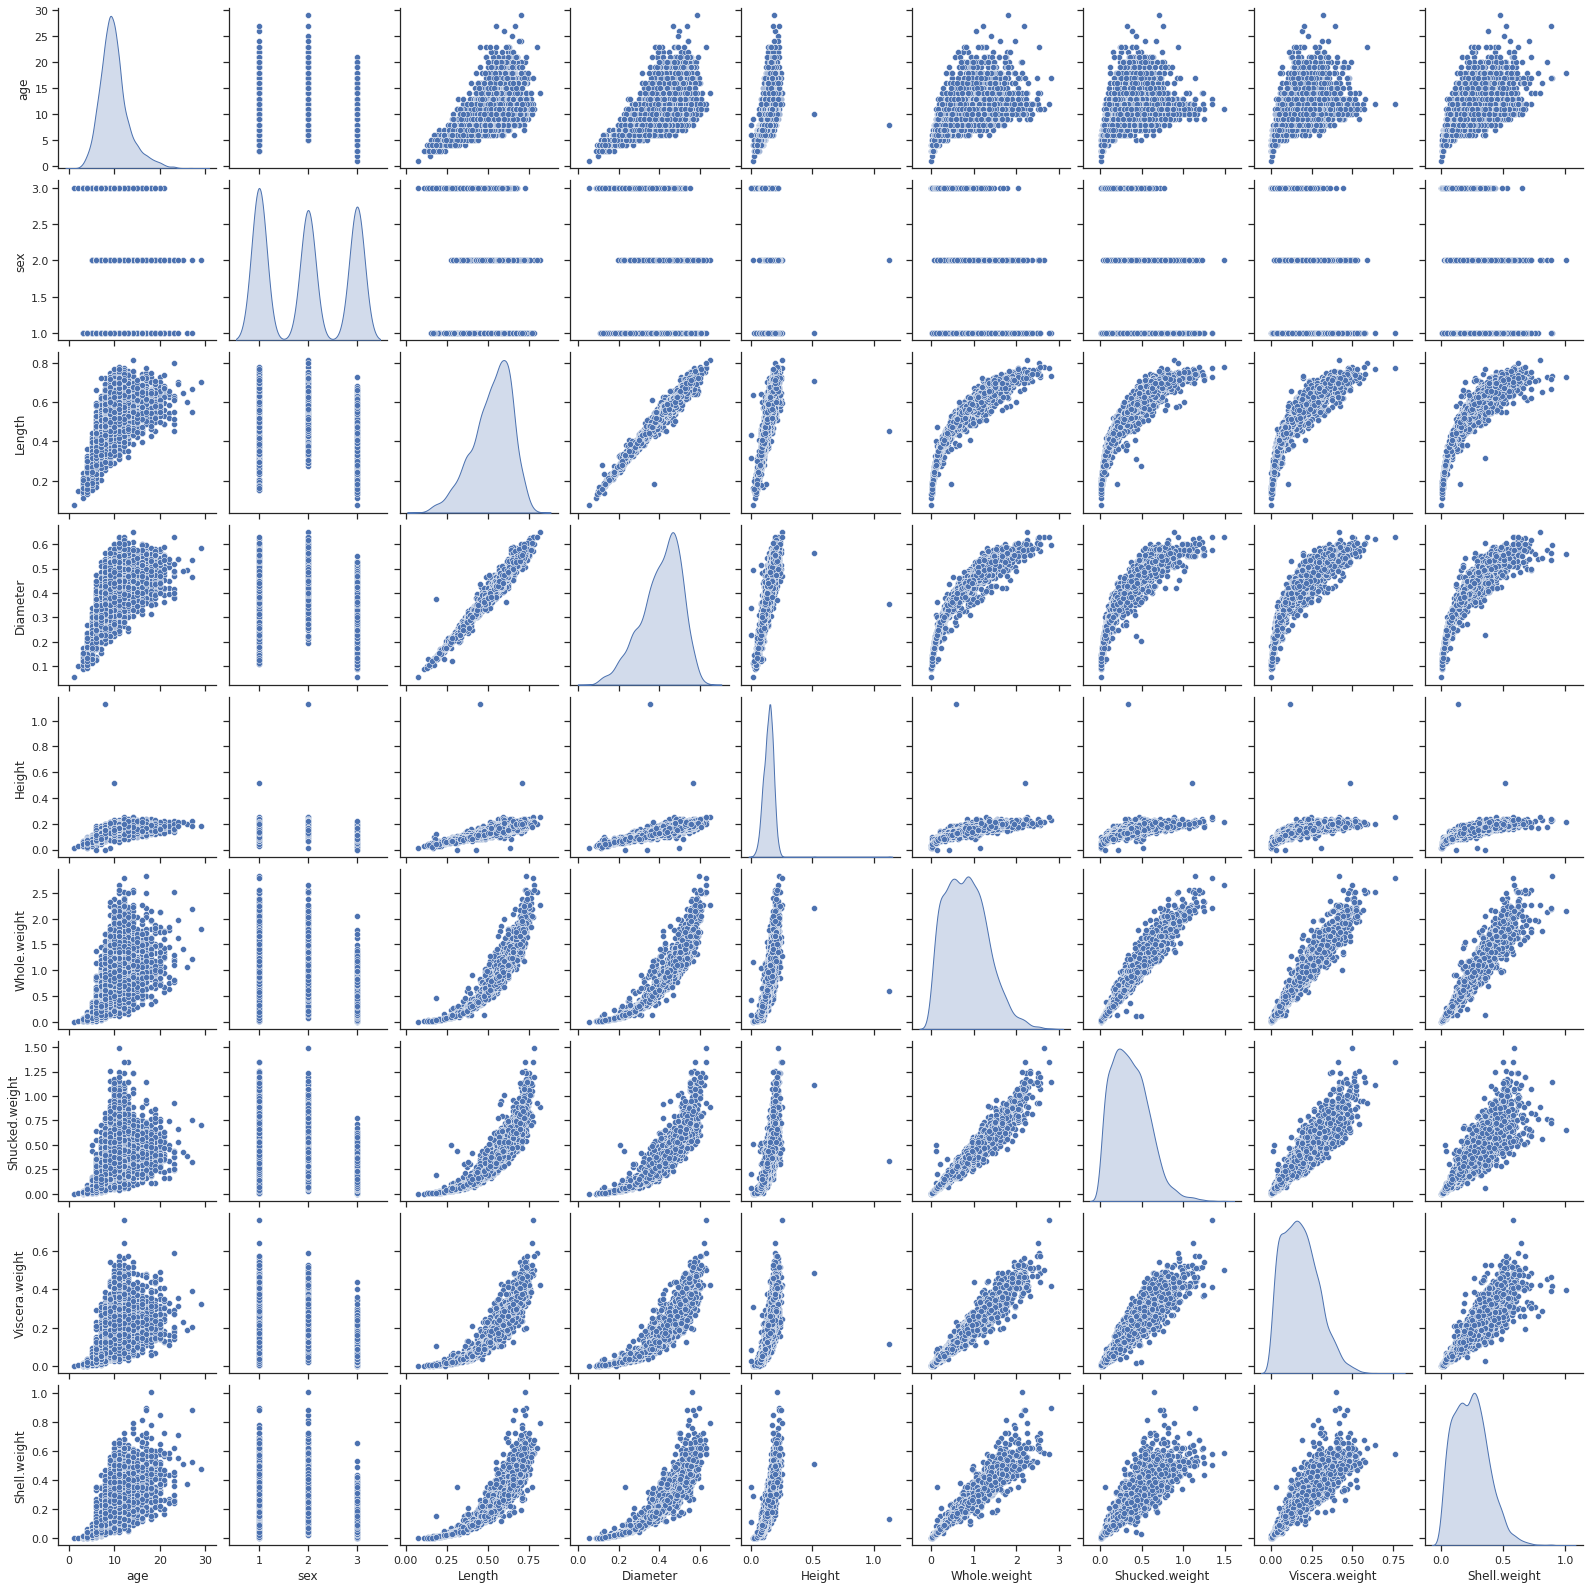

In [47]:
sns.set(style="ticks", color_codes=True)
# g = sns.pairplot(df)
g = sns.pairplot(df, diag_kind='kde')

The data is now clean with no missing values. We will write this clean data to a file:

In [12]:
CLEAN_DATA = "abalone_clean.txt"
# df = df.sample(n=10, random_state=1)
df.to_csv(CLEAN_DATA, sep=',', header=None, index=False)

In [13]:
# hide
!ls -altrh

total 2.9M
drwx------  2 root     root      16K May  6 16:10 lost+found
drwxr-xr-x  2 ec2-user ec2-user 4.0K May  6 16:10 .sparkmagic
-rw-rw-r--  1 ec2-user ec2-user 458K May 19 15:14 hs_err_pid19109.log
-rw-rw-r--  1 ec2-user ec2-user 449K May 19 19:00 PredictContributionEffort_1.ipynb
-rw-rw-rw-  1 ec2-user ec2-user  59K May 20 19:34 PredictContributionEffort_2__pyspark_mnist_xgboost.ipynb
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 21 15:30 .ipynb_checkpoints
-rw-rw-r--  1 ec2-user ec2-user  29K May 21 18:11 abalone_valid.csv
-rw-rw-r--  1 ec2-user ec2-user 132K May 21 18:11 abalone_train.csv
-rw-rw-r--  1 ec2-user ec2-user  29K May 21 18:11 abalone_testg.csv
drwxrwxrwx  3 ec2-user ec2-user 4.0K May 21 21:34 factorization_machines_mnist_2021-05-21
-rw-rw-r--  1 ec2-user ec2-user 1.2M May 21 22:57 Abalone_Regression_SageMaker.ipynb
drwxr-xr-x  6 ec2-user ec2-user 4.0K May 21 22:57 .
drwx------ 22 ec2-user ec2-user 4.0K May 22 16:12 ..
-rw-rw-r--  1 ec2-user ec2-user 253K May 22 16:12 ab

## 3. Data Preparation
What remains is to split the data into suitable partitions for modeling.

In [14]:
def split_data(
    FILE_TOTAL,
    FILE_TRAIN,
    FILE_VALID,
    FILE_TESTG,
    FRAC_TRAIN,
    FRAC_VALID,
    FRAC_TESTG,
):
    total = [row for row in open(FILE_TOTAL, "r")]
    train_file = open(FILE_TRAIN, "w")
    valid_file = open(FILE_VALID, "w")
    testg_file = open(FILE_TESTG, "w")

    num_total = len(total)
    num_train = int(FRAC_TRAIN*num_total)
    num_valid = int(FRAC_VALID*num_total)
    num_testg = int(FRAC_TESTG*num_total)

    sizes = [num_train, num_valid, num_testg]
    splits = [[], [], []]

    rand_total_ind = 0
    #set_trace()
    for split_ind,size in enumerate(sizes):
        for _ in range(size):
            if len(total)<1:
                print('ERROR. Make sure fractions are decimals.')
                break
            rand_total_ind = random.randint(0, len(total) - 1)
            #print('len(total) - 1',len(total) - 1)
            #print('rand_total_ind:',rand_total_ind)
            #print('total[rand_total_ind]:',total[rand_total_ind])
            splits[split_ind].append(total[rand_total_ind])
            total.pop(rand_total_ind)

    for row in splits[0]:
        train_file.write(row)
    print(f'Training data: {len(splits[0])} rows ({len(splits[0])/num_total})')

    for row in splits[1]:
        valid_file.write(row)
    print(f'Validation data: {len(splits[1])} rows ({len(splits[1])/num_total})')

    for row in splits[2]:
        testg_file.write(row)
    print(f'Testing data: {len(splits[2])} rows ({len(splits[2])/num_total})')

    train_file.close()
    valid_file.close()
    testg_file.close()

In [138]:
# Load the dataset
FILE_TOTAL = "abalone_clean.txt"
FILE_TRAIN = "abalone_train.csv"
FILE_VALID = "abalone_valid.csv"
FILE_TESTG = "abalone_testg.csv"
FRAC_TRAIN = .70
FRAC_VALID = .15
FRAC_TESTG = .15
split_data(
    FILE_TOTAL,
    FILE_TRAIN,
    FILE_VALID,
    FILE_TESTG,
    FRAC_TRAIN,
    FRAC_VALID,
    FRAC_TESTG,
)

Training data: 2923 rows (0.6997845343548001)
Validation data: 626 rows (0.1498683265501556)
Testing data: 626 rows (0.1498683265501556)


In [139]:
# hide
!ls -altrh

total 2.6M
drwx------  2 root     root      16K May  6 16:10 lost+found
drwxr-xr-x  2 ec2-user ec2-user 4.0K May  6 16:10 .sparkmagic
-rw-rw-r--  1 ec2-user ec2-user 458K May 19 15:14 hs_err_pid19109.log
-rw-rw-r--  1 ec2-user ec2-user 449K May 19 19:00 PredictContributionEffort_1.ipynb
-rw-rw-rw-  1 ec2-user ec2-user  59K May 20 19:34 PredictContributionEffort_2__pyspark_mnist_xgboost.ipynb
drwxrwxr-x  2 ec2-user ec2-user 4.0K May 21 15:30 .ipynb_checkpoints
-rw-rw-r--  1 ec2-user ec2-user 253K May 21 15:32 abalone_libsvm.txt
drwx------ 22 ec2-user ec2-user 4.0K May 21 16:48 ..
-rw-rw-r--  1 ec2-user ec2-user 188K May 21 18:03 abalone_clean.txt
-rw-rw-r--  1 ec2-user ec2-user  29K May 21 18:11 abalone_valid.csv
-rw-rw-r--  1 ec2-user ec2-user 132K May 21 18:11 abalone_train.csv
-rw-rw-r--  1 ec2-user ec2-user  29K May 21 18:11 abalone_testg.csv
-rw-rw-r--  1 ec2-user ec2-user 943K May 21 18:12 Abalone_Regression_SageMaker.ipynb
drwxr-xr-x  5 ec2-user ec2-user 4.0K May 21 18:12 .


## 4. Modeling
Before we build a model, we want to position the data on S3.

### 4.1 Position data on S3

In [158]:
def write_to_s3(fobj, bucket, key):
    return (
        boto3.Session(region_name=region)
        .resource("s3")
        .Bucket(bucket)
        .Object(key)
        .upload_fileobj(fobj)
    )

def upload_to_s3(bucket, prefix, channel, filename):
    fobj = open(filename, "rb")
    key = f"{prefix}/{channel}/{filename}"
    url = f"s3://{bucket}/{key}"
    print(f"Writing to {url}")
    write_to_s3(fobj, bucket, key)

In [156]:
# upload the files to the S3 bucket
upload_to_s3(bucket, prefix, "train", FILE_TRAIN)
upload_to_s3(bucket, prefix, "valid", FILE_VALID)
upload_to_s3(bucket, prefix, "testg", FILE_TESTG)

Writing to s3://learnableloopai-blog/abalone/train/abalone_train.csv
Writing to s3://learnableloopai-blog/abalone/valid/abalone_valid.csv
Writing to s3://learnableloopai-blog/abalone/testg/abalone_testg.csv


In [3]:
# hide
!aws s3 ls

2021-05-06 17:40:08 776779151861-sagemaker-us-west-2
2021-05-06 02:51:44 aws-emr-resources-776779151861-us-west-2
2021-05-21 18:24:44 learnableloopai-blog
2021-05-11 17:59:27 sagemaker-studio-776779151861-89hkk9e6uzv
2021-05-12 19:48:24 sagemaker-studio-776779151861-k5ps7zp0njh
2021-05-16 12:55:13 todproof-batch-translations
2021-05-05 23:50:17 todproof-contributions-archive


### 4.2 Setup data channels

In [20]:
s3_train_data = f"s3://{bucket}/{prefix}/train"
print(f"training files will be taken from: {s3_train_data}")
s3_valid_data = f"s3://{bucket}/{prefix}/valid"
print(f"validation files will be taken from: {s3_valid_data}")
s3_testg_data = f"s3://{bucket}/{prefix}/testg"
print(f"testing files will be taken from: {s3_testg_data}")

s3_output = f"s3://{bucket}/{prefix}/output"
print(f"training artifacts output location: {s3_output}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
valid_data = sagemaker.inputs.TrainingInput(
    s3_valid_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
testg_data = sagemaker.inputs.TrainingInput(
    s3_testg_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

training files will be taken from: s3://learnableloopai-blog/abalone/train
validation files will be taken from: s3://learnableloopai-blog/abalone/valid
testing files will be taken from: s3://learnableloopai-blog/abalone/testg
training artifacts output location: s3://learnableloopai-blog/abalone/output


### 4.3 Training a Linear Learner model

First, we retrieve the image for the Linear Learner Algorithm according to the region.

Then we create an [estimator from the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) using the Linear Learner container image and we setup the training parameters and hyperparameters configuration.


In [3]:
# 
# get the linear learner image
image_uri = retrieve("linear-learner", boto3.Session().region_name, version="1")

In [4]:
# hide
print(image_uri)

174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:1


In [35]:
# hide
# hyperparameters = {
#     "feature_dim": "8",
#     "epochs": "16",
#     "wd": "0.01",
#     "loss": "absolute_loss",
#     "predictor_type": "regressor",
#     "normalize_data": True,
#     "optimizer": "adam",
#     "mini_batch_size": "100",
#     "lr_scheduler_step": "100",
#     "lr_scheduler_factor": "0.99",
#     "lr_scheduler_minimum_lr": "0.0001",
#     "learning_rate": "0.1",
# }

In [24]:
# hide
# Debugger resources
# https://www.youtube.com/watch?v=8b5-lyRaFgA
# https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-debugger/xgboost_census_explanations/xgboost-census-debugger-rules.html
# https://aws.amazon.com/blogs/machine-learning/ml-explainability-with-amazon-sagemaker-debugger/

In [25]:
# hide
s3_output

's3://learnableloopai-blog/abalone/output'

In [26]:
%%time
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
save_interval = 3
sess = sagemaker.Session()
job_name = "abalone-regression-" + strftime("%H-%M-%S", gmtime())
print("Training job: ", job_name)
linear = sagemaker.estimator.Estimator(
    image_uri=image_uri, 
    role=role, 
    instance_count=1, 
    instance_type="ml.m4.xlarge", 
    #instance_type="local", 
    input_mode="File", 
    output_path=s3_output, 
    base_job_name="abalone-regression-sagemaker",
    sagemaker_session=sess, 
    #hyperparameters=hyperparameters,
    #train_max_run=100
    debugger_hook_config=DebuggerHookConfig(
        #s3_output_path="s3://learnableloopai-blog/abalone/output_debugger",
        s3_output_path=s3_output,
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": str(save_interval)
                }
            ),
#             CollectionConfig(
#                 name="feature_importance",
#                 parameters={
#                     "save_interval": str(save_interval)
#                 }
#             ),
#             CollectionConfig(
#                 name="full_shap",
#                 parameters={
#                     "save_interval": str(save_interval)
#                 }
#             ),
#             CollectionConfig(
#                 name="average_shap",
#                 parameters={
#                     "save_interval": str(save_interval)
#                 }
#             ),            
#             CollectionConfig(
#                 name="mini_batch_size",
#                 parameters={
#                     "save_interval": str(save_interval)
#                 }
#             )
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": str(save_interval*2),
            },
        ),
#         Rule.sagemaker(
#             rule_configs.overtraining(),
#             rule_parameters={
#                 "collection_names": "metrics",
#                 "patience_validation": str(10),
#             },
#         ),
#         Rule.sagemaker(
#             rule_configs.overfit(),
#             rule_parameters={
#                 "collection_names": "metrics",
#                 "patience": str(10),
#             },
#         )
    ]
)

Training job:  abalone-regression-13-02-13
CPU times: user 13.3 ms, sys: 45 µs, total: 13.4 ms
Wall time: 12.5 ms


In [27]:
linear.set_hyperparameters(
    feature_dim=8,
    epochs=16,
    wd=0.01,
    loss="absolute_loss",
    predictor_type="regressor",
    normalize_data=True,
    optimizer="adam",
    mini_batch_size=100,
    lr_scheduler_step=100,
    lr_scheduler_factor=0.99,
    lr_scheduler_minimum_lr=0.0001,
    learning_rate=0.1,
)

In [28]:
# hide
#--- linear.fit??

In [29]:
%%time
linear.fit(inputs={
    "train": train_data, 
    "validation": valid_data,
    #"test": testg_data
    }, 
    wait=False) #cell won't block until done

CPU times: user 35.6 ms, sys: 130 µs, total: 35.7 ms
Wall time: 231 ms


In [18]:
# hide
# import time
# for _ in range(360):
#     job_name = linear.latest_training_job.name
#     client = linear.sagemaker_session.sagemaker_client
#     description = client.describe_training_job(TrainingJobName=job_name)
#     training_job_status = description["TrainingJobStatus"]
#     rule_job_summary = linear.latest_training_job.rule_job_summary()
#     rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
#     print("Training Job Status: {}, Rule Evaluation Status: {}".format(training_job_status, rule_evaluation_status))
#     if rule_evaluation_status in ["Stopped", "IssuesFound", "NoIssuesFound"]:
#         break
#     time.sleep(10)

In [30]:
# hide
import time
for _ in range(36):
    job_name = linear.latest_training_job.name
    client = linear.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = linear.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

In [31]:
# hide
linear.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:776779151861:processing-job/abalone-regression-sagemak-lossnotdecreasing-b2867125',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2021, 5, 24, 13, 7, 21, 209000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport-1621861344',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:776779151861:processing-job/abalone-regression-sagemak-profilerreport-1621861344-f1b07671',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2021, 5, 24, 13, 7, 9, 77000, tzinfo=tzlocal())}]

In [32]:
# hide
# Analyze debugger output
# ERROR:
# https://stackoverflow.com/questions/65812334/sagemaker-debugger-service-gives-missingcollectionfiles-error
from smdebug.trials import create_trial
s3_output_path = linear.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2021-05-24 13:07:26.738 ip-172-16-88-149:24442 INFO s3_trial.py:42] Loading trial debug-output at path s3://learnableloopai-blog/abalone/output/abalone-regression-sagemaker-2021-05-24-13-02-24-333/debug-output


MissingCollectionFiles: Training job has ended. All the collection files could not be loaded

In [16]:
# hide
trial.tensor_names()

NameError: name 'trial' is not defined

In [ ]:
# hide
def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.values(s) for s in steps]
    return steps, vals
def plot_collection(trial, collection_name, regex=

## 6. Deployment

In [165]:
%%time
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.c4.xlarge")
print(f"\nEndpoint: {linear_predictor.endpoint_name}")

---------------!
Endpoint: linear-learner-2021-05-21-19-45-14-793
CPU times: user 270 ms, sys: 12.6 ms, total: 283 ms
Wall time: 7min 32s


### 6.1 Test Inference

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, we are going to configure the [predictor object](https://sagemaker.readthedocs.io/en/v1.2.4/predictors.html) to parse contents of type text/csv and deserialize the reply received from the endpoint to json format.


In [166]:
# configure the predictor to accept to serialize csv input and parse the reponse as json
linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

---
We use the test file containing the records of the data that we kept to test the model prediction. Run the following cell multiple times to perform inference:

In [177]:
%%time
# get a testing sample from the test file
test_data = [row for row in open(FILE_TESTG, "r")]
sample = random.choice(test_data).split(",")
actual_age = sample[0]
payload = sample[1:]  # removing actual age from the sample
payload = ",".join(map(str, payload))

# invoke the predicor and analyise the result
result = linear_predictor.predict(payload)

# extract the prediction value
result = round(float(result["predictions"][0]["score"]), 2)

accuracy = str(round(100 - ((abs(float(result) - float(actual_age)) / float(actual_age)) * 100), 2))
print(f"Actual age: {actual_age}\nPrediction: {result}\nAccuracy: {accuracy}")

Actual age: 9
Prediction: 8.83
Accuracy: 98.11
CPU times: user 4.66 ms, sys: 0 ns, total: 4.66 ms
Wall time: 19.6 ms


### 6.2 Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [178]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint_name)
print(f"Deleted {linear_predictor.endpoint_name} successfully!")

Deleted linear-learner-2021-05-21-19-45-14-793 successfully!
